## Face Detection 실습

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import math
import numpy as np
from collections import OrderedDict
from PIL import Image, ImageDraw, ImageFont

from box_utils import nms, calibrate_box, get_image_boxes, convert_to_square, _preprocess

## MTCNN Model

![MTCNN1](image/MTCNN1.png)

![MTCNN2](image/MTCNN2.png)

In [10]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, c, h, w].
        Returns:
            a float tensor with shape [batch_size, c*h*w].
        """

        # without this pretrained model isn't working
        x = x.transpose(3, 2).contiguous()

        return x.view(x.size(0), -1)

## P-Net

In [11]:
class PNet(nn.Module):
    def __init__(self):
        super(PNet, self).__init__()
        # suppose we have input with size HxW, then
        # after first layer: H - 2,
        # after pool: ceil((H - 2)/2),
        # after second conv: ceil((H - 2)/2) - 2,
        # after last conv: ceil((H - 2)/2) - 4,
        # and the same for W

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 10, 3, 1)),
            ('prelu1', nn.PReLU(10)),
            ('pool1', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(10, 16, 3, 1)),
            ('prelu2', nn.PReLU(16)),

            ('conv3', nn.Conv2d(16, 32, 3, 1)),
            ('prelu3', nn.PReLU(32))
        ]))

        self.conv4_1 = nn.Conv2d(32, 2, 1, 1)
        self.conv4_2 = nn.Conv2d(32, 4, 1, 1)

        weights = np.load('weights/pnet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            b: a float tensor with shape [batch_size, 4, h', w'].
            a: a float tensor with shape [batch_size, 2, h', w'].
        """
        x = self.features(x)
        a = self.conv4_1(x)
        b = self.conv4_2(x) # Bounding Box Regression
        a = F.softmax(a, dim=1) # Face Classification
        return b, a

## R-Net

In [12]:
class RNet(nn.Module):
    def __init__(self):
        super(RNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 28, 3, 1)),
            ('prelu1', nn.PReLU(28)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(28, 48, 3, 1)),
            ('prelu2', nn.PReLU(48)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(48, 64, 2, 1)),
            ('prelu3', nn.PReLU(64)),

            ('flatten', Flatten()),
            ('conv4', nn.Linear(576, 128)),
            ('prelu4', nn.PReLU(128))
        ]))

        self.conv5_1 = nn.Linear(128, 2)
        self.conv5_2 = nn.Linear(128, 4)

        weights = np.load('weights/rnet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            b: a float tensor with shape [batch_size, 4].
            a: a float tensor with shape [batch_size, 2].
        """
        x = self.features(x)
        a = self.conv5_1(x) 
        b = self.conv5_2(x) # Bounding Box Regression
        a = F.softmax(a, dim=1) # Face Classification
        return b, a

## O-Net

In [14]:
class ONet(nn.Module):
    def __init__(self):
        super(ONet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 32, 3, 1)),
            ('prelu1', nn.PReLU(32)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('prelu2', nn.PReLU(64)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(64, 64, 3, 1)),
            ('prelu3', nn.PReLU(64)),
            ('pool3', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv4', nn.Conv2d(64, 128, 2, 1)),
            ('prelu4', nn.PReLU(128)),

            ('flatten', Flatten()),
            ('conv5', nn.Linear(1152, 256)),
            ('drop5', nn.Dropout(0.25)),
            ('prelu5', nn.PReLU(256)),
        ]))

        self.conv6_1 = nn.Linear(256, 2)
        self.conv6_2 = nn.Linear(256, 4)
        self.conv6_3 = nn.Linear(256, 10)

        weights = np.load('weights/onet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            c: a float tensor with shape [batch_size, 10].
            b: a float tensor with shape [batch_size, 4].
            a: a float tensor with shape [batch_size, 2].
        """
        x = self.features(x)
        a = self.conv6_1(x)
        b = self.conv6_2(x) # Bounding Box Regression
        c = self.conv6_3(x) # Face Landmark Detection
        a = F.softmax(a, dim=1) # Face Classification
        return c, b, a

## Run P-Net, Generate Bounding boxes and do NMS

In [13]:
def run_first_stage(image, net, scale, threshold):
    """Run P-Net, generate bounding boxes, and do NMS.

    Arguments:
        image: an instance of PIL.Image.
        net: an instance of pytorch's nn.Module, P-Net.
        scale: a float number,
            scale width and height of the image by this number.
        threshold: a float number,
            threshold on the probability of a face when generating
            bounding boxes from predictions of the net.

    Returns:
        a float numpy array of shape [n_boxes, 9],
            bounding boxes with scores and offsets (4 + 1 + 4).
    """

    # scale the image and convert it to a float array
    width, height = image.size
    sw, sh = math.ceil(width*scale), math.ceil(height*scale)
    img = image.resize((sw, sh), Image.BILINEAR)
    img = np.asarray(img, 'float32')

    with torch.no_grad():
        img = Variable(torch.FloatTensor(_preprocess(img)))
        if torch.cuda.is_available():
            img = img.cuda()
            net = net.cuda()
    output = net(img)
    probs = output[1].data.cpu().numpy()[0, 1, :, :]
    offsets = output[0].data.cpu().numpy()
    # probs: probability of a face at each sliding window
    # offsets: transformations to true bounding boxes

    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None

    keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
    return boxes[keep]


def _generate_bboxes(probs, offsets, scale, threshold):
    """Generate bounding boxes at places
    where there is probably a face.

    Arguments:
        probs: a float numpy array of shape [n, m].
        offsets: a float numpy array of shape [1, 4, n, m].
        scale: a float number,
            width and height of the image were scaled by this number.
        threshold: a float number.

    Returns:
        a float numpy array of shape [n_boxes, 9]
    """

    # applying P-Net is equivalent, in some sense, to
    # moving 12x12 window with stride 2
    stride = 2
    cell_size = 12

    # indices of boxes where there is probably a face
    inds = np.where(probs > threshold)

    if inds[0].size == 0:
        return np.array([])

    # transformations of bounding boxes
    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
    # they are defined as:
    # w = x2 - x1 + 1
    # h = y2 - y1 + 1
    # x1_true = x1 + tx1*w
    # x2_true = x2 + tx2*w
    # y1_true = y1 + ty1*h
    # y2_true = y2 + ty2*h

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]

    # P-Net is applied to scaled images
    # so we need to rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride*inds[1] + 1.0)/scale),
        np.round((stride*inds[0] + 1.0)/scale),
        np.round((stride*inds[1] + 1.0 + cell_size)/scale),
        np.round((stride*inds[0] + 1.0 + cell_size)/scale),
        score, offsets
    ])
    # why one is added?

    return bounding_boxes.T

## Detect Faces

In [15]:
def detect_faces(image, min_face_size=20.0,
                 thresholds=[0.6, 0.7, 0.8],
                 nms_thresholds=[0.7, 0.7, 0.7]):
    """
    Arguments:
        image: an instance of PIL.Image.
        min_face_size: a float number.
        thresholds: a list of length 3.
        nms_thresholds: a list of length 3.

    Returns:
        two float numpy arrays of shapes [n_boxes, 4] and [n_boxes, 10],
        bounding boxes and facial landmarks.
    """

    # LOAD MODELS
    pnet = PNet()
    rnet = RNet()
    onet = ONet()
    onet.eval()

    # BUILD AN IMAGE PYRAMID
    width, height = image.size
    min_length = min(height, width)

    min_detection_size = 12
    factor = 0.707  # sqrt(0.5)

    # scales for scaling the image
    scales = []

    # scales the image so that
    # minimum size that we can detect equals to
    # minimum face size that we want to detect
    m = min_detection_size/min_face_size
    min_length *= m

    factor_count = 0
    # scales = [0.6, 0.42, 0.30, 0.21, 0.15, 0.10, 0.07, 0.05, 0.03]
    while min_length > min_detection_size:
        scales.append(m*factor**factor_count)
        min_length *= factor
        factor_count += 1

    # STAGE 1

    # it will be returned
    bounding_boxes = []

    # run P-Net on different scales
    for s in scales:
        boxes = run_first_stage(image, pnet, scale=s, threshold=thresholds[0])
        bounding_boxes.append(boxes)

    # collect boxes (and offsets, and scores) from different scales
    bounding_boxes = [i for i in bounding_boxes if i is not None]
    bounding_boxes = np.vstack(bounding_boxes)

    keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0]) # NMS (Non-Maximum-Suppression)
    bounding_boxes = bounding_boxes[keep]

    # use offsets predicted by pnet to transform bounding boxes
    bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
    # shape [n_boxes, 5]

    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

    # STAGE 2

    img_boxes = get_image_boxes(bounding_boxes, image, size=24)
    with torch.no_grad():
        img_boxes = Variable(torch.FloatTensor(img_boxes))
        if torch.cuda.is_available():
            rnet = rnet.cuda()
            img_boxes = img_boxes.cuda()
    output = rnet(img_boxes)
    offsets = output[0].data.cpu().numpy()  # shape [n_boxes, 4]
    probs = output[1].data.cpu().numpy()  # shape [n_boxes, 2]

    keep = np.where(probs[:, 1] > thresholds[1])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]

    keep = nms(bounding_boxes, nms_thresholds[1]) # NMS (Non-Maximum-Suppression)
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

    # STAGE 3

    img_boxes = get_image_boxes(bounding_boxes, image, size=48)
    if len(img_boxes) == 0:
        return [], []
    with torch.no_grad():
        img_boxes = Variable(torch.FloatTensor(img_boxes))
        if torch.cuda.is_available():
            onet = onet.cuda()
            img_boxes = img_boxes.cuda()
    output = onet(img_boxes)
    landmarks = output[0].data.cpu().numpy()  # shape [n_boxes, 10]
    offsets = output[1].data.cpu().numpy()  # shape [n_boxes, 4]
    probs = output[2].data.cpu().numpy()  # shape [n_boxes, 2]

    keep = np.where(probs[:, 1] > thresholds[2])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]
    landmarks = landmarks[keep]

    # compute landmark points
    width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
    height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
    xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]
    landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*landmarks[:, 0:5]
    landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*landmarks[:, 5:10]

    bounding_boxes = calibrate_box(bounding_boxes, offsets)
    keep = nms(bounding_boxes, nms_thresholds[2], mode='min') # NMS (Non-Maximum-Suppression)
    bounding_boxes = bounding_boxes[keep]
    landmarks = landmarks[keep]

    return bounding_boxes, landmarks

## Visualization

In [16]:
def show_bboxes(img, bounding_boxes, facial_landmarks=[]):
    """Draw bounding boxes and facial landmarks.

    Arguments:
        img: an instance of PIL.Image.
        bounding_boxes: a float numpy array of shape [n, 5].
        facial_landmarks: a float numpy array of shape [n, 10].

    Returns:
        an instance of PIL.Image.
    """

    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)

    # Draw Bounding boxes
    for b in bounding_boxes:
        draw.rectangle([
            (b[0], b[1]), (b[2], b[3])
        ], outline='white')

    # Draw Facial Landmarks
    for p in facial_landmarks:
        for i in range(5):
            draw.ellipse([
                (p[i] - 1.0, p[i + 5] - 1.0),
                (p[i] + 1.0, p[i + 5] + 1.0)
            ], outline='blue')

    return img_copy

## Results

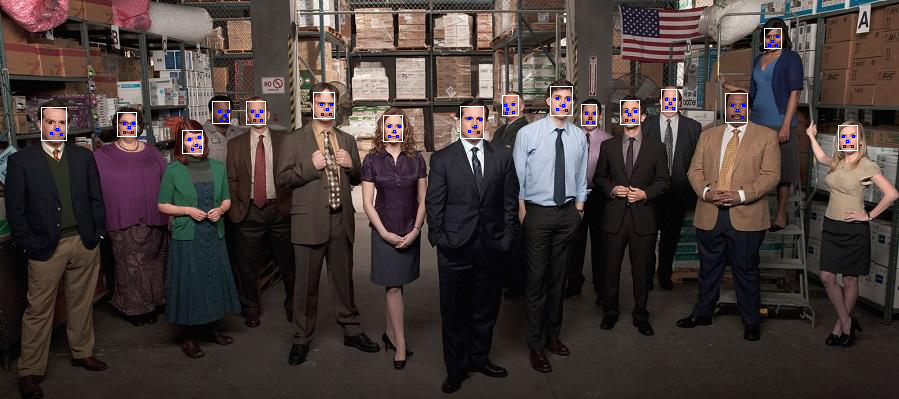

In [17]:
img = Image.open('image/office1.jpg')

bounding_boxes, landmarks = detect_faces(img)
show_bboxes(img, bounding_boxes, landmarks)

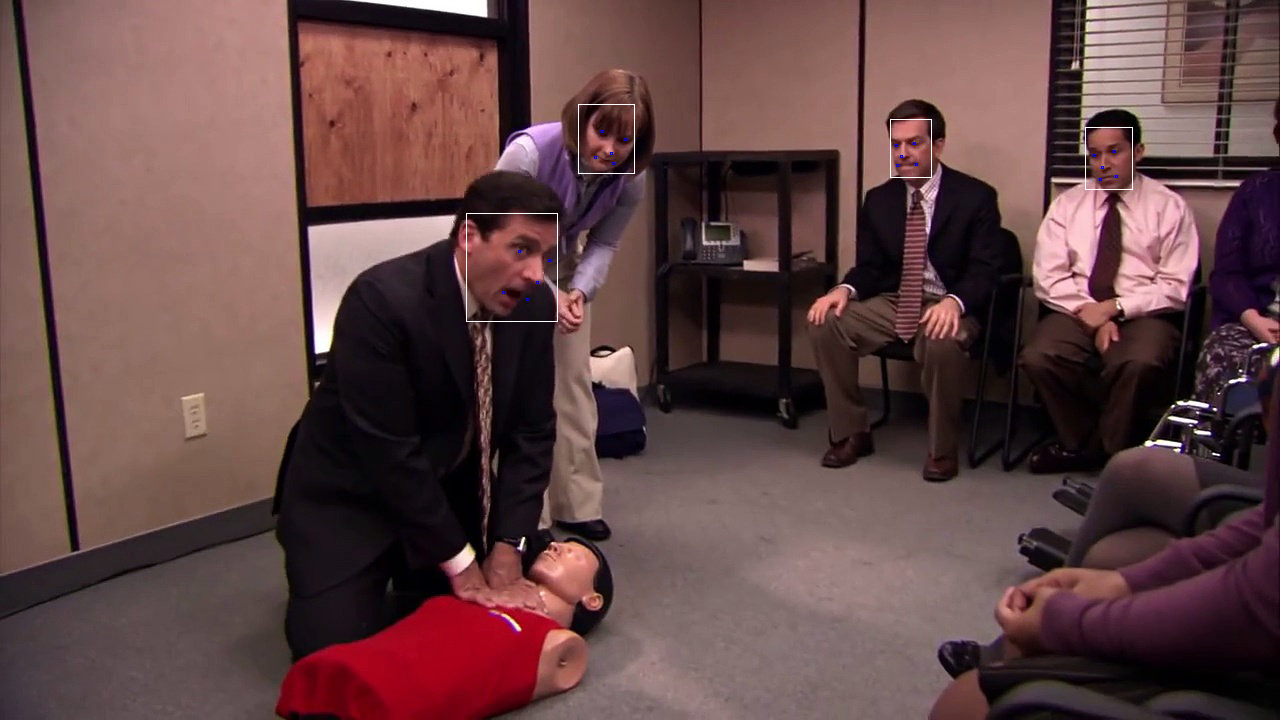

In [18]:
img = Image.open('image/office2.jpg')

bounding_boxes, landmarks = detect_faces(img)
show_bboxes(img, bounding_boxes, landmarks)

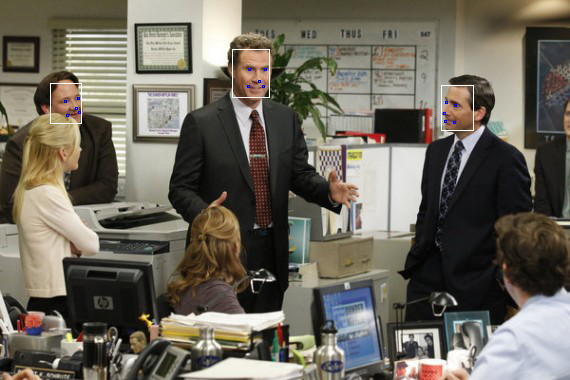

In [19]:
img = Image.open('image/office3.jpg')

bounding_boxes, landmarks = detect_faces(img)
show_bboxes(img, bounding_boxes, landmarks)

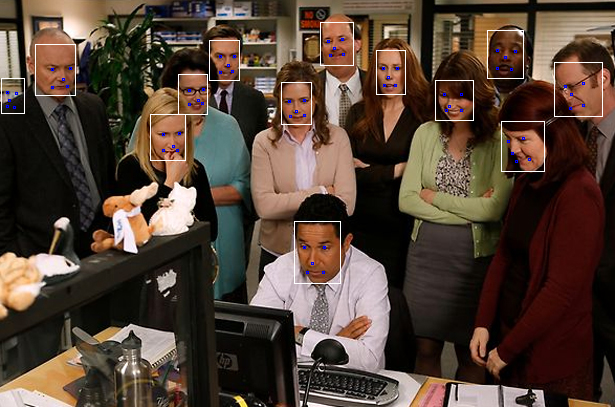

In [20]:
img = Image.open('image/office4.jpg')

bounding_boxes, landmarks = detect_faces(img)
show_bboxes(img, bounding_boxes, landmarks)

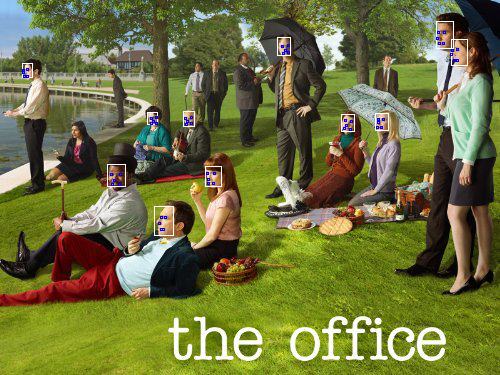

In [21]:
img = Image.open('image/office5.jpg')

bounding_boxes, landmarks = detect_faces(img)
show_bboxes(img, bounding_boxes, landmarks)

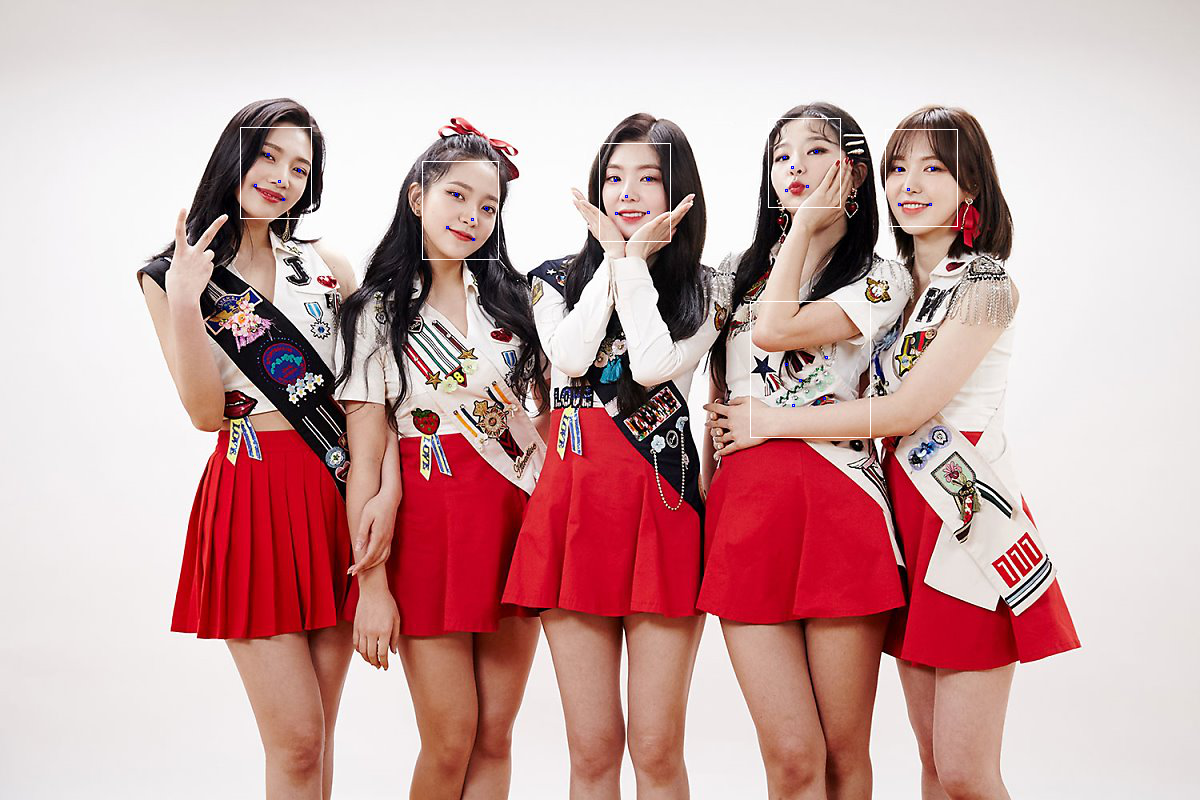

In [22]:
img = Image.open('image/image1.jpg')

bounding_boxes, landmarks = detect_faces(img)
show_bboxes(img, bounding_boxes, landmarks)

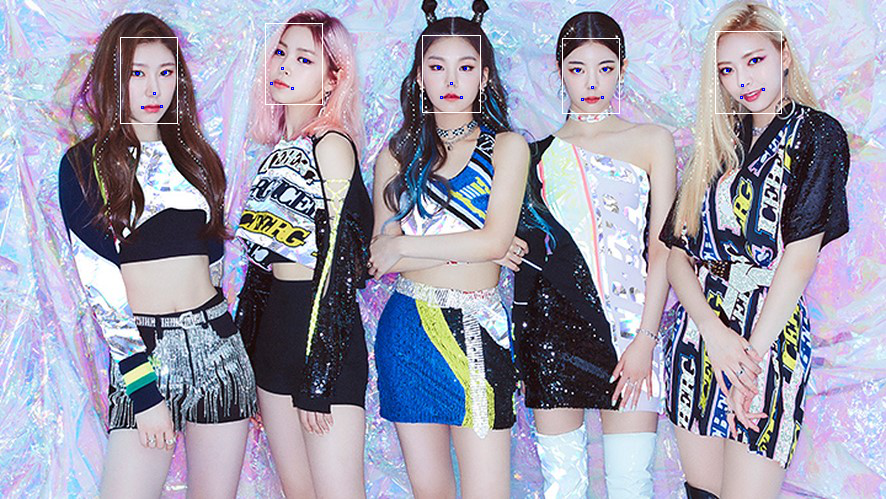

In [23]:
img = Image.open('image/image2.jpg')

bounding_boxes, landmarks = detect_faces(img)
show_bboxes(img, bounding_boxes, landmarks)

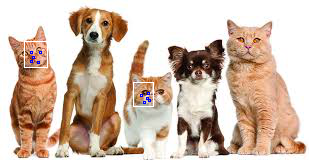

In [24]:
img = Image.open('image/image3.jpg')

bounding_boxes, landmarks = detect_faces(img)
show_bboxes(img, bounding_boxes, landmarks)

In [ ]:
img = Image.open('image/image4.jpg')

bounding_boxes, landmarks = detect_faces(img)
show_bboxes(img, bounding_boxes, landmarks)